In [377]:
'''Gameplan:
Imports @done, add as needed, though
Create NN
Parameters (learning rate, etc) @set?
Initialize Data @done?
Load Data  @done?
Normalize Data  @done
Initialization @done?
Loss Function @is that really all we need to do? 
Optimizer @doesnt exist
Training
Check Accuracy
'''
#imports
import numpy as np
import math
import pandas as pd
import torch #pytorch
import torch.nn as nn #nn shiz and loss functions
import torch.optim as optim #optimization things
import torch.nn.functional as F #activation functions are here
from torch.utils.data import Dataset, DataLoader #Make minibatches and things like that
import torchvision.datasets as datasets #standard datasets?
import torchvision.transforms as transforms #transformations on dataset


class BinaryDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array

    def __len__(self):
        return len(self.input_array)

    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

#Create NN
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(7,14),
        nn.ReLU(),
        nn.Linear(14,21),
        nn.ReLU(),
        nn.Linear(21,42),
        nn.ReLU(),
        nn.Linear(42,21),
        nn.ReLU(),
        nn.Linear(21,1),
        #nn.Sigmoid(),
    )
    def forward(self, x):
        output = self.linear_relu_stack(x)     
        return torch.sigmoid(output) # changed this from nn.functional since that sigmoid is deprecated

In [378]:
#hyperparameters
learning_rate = 0.5
momentum = 0.5
batchSize = 2000
num_epochs = 5

In [379]:
#initialize data, get rid of unwanted data
def readCSV(filename):
    df=pd.read_csv(filename, names = ['index','phi1','phi2','eta1','eta2','diphi','deta','deltaR','genweight','recoweight'])
    data = df.copy()
    #taking out columns we don't need
    data.drop(columns='index',inplace=True)
    data.drop(columns='genweight',inplace=True)
    data.drop(columns='recoweight',inplace=True)
    return data

In [380]:
df = readCSV('SUSY.txt') #replace with path
df2 = readCSV('ttbarsignalplustau_mainSignal.txt') #replace with path
#df = df[:5] #disregard, for troubleshooting
#df2 = df2[:5] #disregard
df2 = df2[:6760]#make df and df2 same size

In [381]:
#normalize
def normalize(data):
    data['phi1'] = data['phi1']/math.pi
    data['phi2'] = data['phi2']/math.pi
    data['eta1'] = data['eta1']/data['eta1'].abs().max() #now the max value will be plus/minus 1
    data['eta2'] = data['eta2']/data['eta2'].abs().max()
    data['diphi'] = data['diphi']/data['diphi'].abs().max()
    data['deta'] = data['deta']/data['deta'].abs().max()
    data['deltaR'] = data['deltaR']/data['deltaR'].abs().max()
    return data

In [391]:
df = normalize(df)
df2 = normalize(df2)

#identifier = [0] * 5#for troubleshooting, disregard
identifier = [0] * 6760
identifier2 = [1] * 6760
df['identifier'] = identifier2
df2['identifier'] = identifier #adds an extra column (identifier) to df and df2

#more data initialization
frames = [df,df2]
#print('\n\nframes:',frames)
wholedata = pd.concat(frames)
#print('\n\nwholedata:',wholedata)
wholedata = wholedata.to_numpy()
#print('\n\nwholedata:',wholedata)
np.random.shuffle(wholedata)
#print('--------\n',wholedata)

trainx=wholedata[:(round(0.8*len(wholedata[:,2])))]
testx=wholedata[:(round(0.2*len(wholedata[:,2])))]

phi1x,phi2x,eta1x,eta2x,dihpix,detax,deltaRx,identifierx=np.hsplit(trainx,8)
phi1y,phi2y,eta1y,eta2y,dihpiy,detay,deltaRy,identifiery=np.hsplit(testx,8)

trainX=np.concatenate((phi1x,phi2x,eta1x,eta2x,dihpix,detax,deltaRx),axis=1)
trainY=identifierx
testX=np.concatenate((phi1y,phi2y,eta1y,eta2y,dihpiy,detay,deltaRy),axis=1)
testY=identifiery

In [383]:
#Load data
train_dataset = BinaryDataset(trainX.astype(np.single),trainY.astype(np.single))
test_dataset = BinaryDataset(testX,testY)
#print(train_dataset.printarray().shape)
train_dataloader = DataLoader(train_dataset, batch_size=batchSize, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=batchSize, shuffle = False)

In [384]:
#initialize NN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

In [385]:
#Loss function 
loss_fn = nn.BCELoss()
#optimizer trial 5:20 pm 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)#,momentum=momentum) # the learning algorithm

In [386]:
# train that 
def train_epoch(dataloader, model, loss_fn):
    model.train()
    correct = 0
    train_losses = []
    oldmod = list(model.parameters())
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
                
        train_losses.append(loss.item())
        correct += (((torch.sigmoid(pred) > 0.5) * 1.0) == y).sum()
        
    print(f"train correct: {correct}")
    print(f"Train Accuracy: {correct/len(dataloader.dataset)}")
    print(f"Model update?: {oldmod!=list(model.parameters())}")
    return train_losses

def test_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (((torch.sigmoid(pred) > 0.5) * 1.0) == y).sum()
    print(f"correct: {correct} length: {len(dataloader.dataset)}")
    print(f"Test Avg Loss: {test_loss/len(dataloader)}, Test Accuracy: {correct/len(dataloader.dataset)}")
    return test_loss/len(dataloader)

In [387]:
#Train network
train_losses = []
test_losses = []

for n in range(num_epochs):
    print(f"Epoch Nr. {n+1} -----------------------")
    train_losses += train_epoch(train_dataloader, model, loss_fn)
    test_losses.append(test_epoch(test_dataloader, model, loss_fn))
    print("")

Epoch Nr. 1 -----------------------
train correct: 5390
Train Accuracy: 0.4983358085155487
Model update?: False
correct: 1322 length: 2704
Test Avg Loss: 0.6928925514221191, Test Accuracy: 0.48890531063079834

Epoch Nr. 2 -----------------------
train correct: 5390
Train Accuracy: 0.4983358085155487
Model update?: False
correct: 1322 length: 2704
Test Avg Loss: 0.6929479241371155, Test Accuracy: 0.48890531063079834

Epoch Nr. 3 -----------------------
train correct: 5390
Train Accuracy: 0.4983358085155487
Model update?: False
correct: 1322 length: 2704
Test Avg Loss: 0.6929627060890198, Test Accuracy: 0.48890531063079834

Epoch Nr. 4 -----------------------
train correct: 5390
Train Accuracy: 0.4983358085155487
Model update?: False
correct: 1322 length: 2704
Test Avg Loss: 0.6931074261665344, Test Accuracy: 0.48890531063079834

Epoch Nr. 5 -----------------------
train correct: 5390
Train Accuracy: 0.4983358085155487
Model update?: False
correct: 1322 length: 2704
Test Avg Loss: 0.6930

In [388]:
len(train_losses)

30

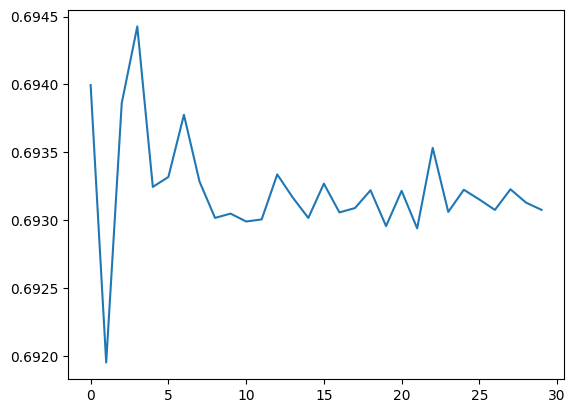

In [389]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [390]:
list(model.parameters())[0].grad is not None

True